<a href="https://colab.research.google.com/github/firesworder/Ml-Staff/blob/main/TFOD_Lol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Задача
Детектирование персонажей в Лолке.
### Датасет: 
Нарежу картинок с bounding box из игры, не конретного персонажа, а всех персонажей на карте.  
Возьму 3-4 видео с киберспорта, из каждой вырежу по 50 картинок, желательно, чтобы разные персонажи были.  
### Модели:
Модели беру изначально крутые, т.к. задача ожидается быть очень сложной(даже мне сложновато различить порой).
### Ожидаемый результат:
Результат ожидаемый: всех знакомых персонажей сетке она распознает, в т.ч. и в скинах.  
Было бы замечательно, если я в паре с cv2(или еще какими библиотеками), смогу детекцию сразу в игровом видео делать(каеф будет).

Готовые модели детекции:
1. Tensorflow Object Detection API(есть пример в практике)

## Upd. To Do
1. Можно использовать модель детекции, что есть в обучалке, т.е. Tensorflow Obj Detection Api, с бейз модел в виде мобайлнет(ну или эффишент нет).  
Эта модель из обучалки(SSD + mobilenet) - вполне себе подойдет и для боевой задачи детекции для Lol бота.
2. Данные(картинки и аннотации к ним), судя по обучалке - у меня уже есть.  
Т.е. класс + баундинг бокс
3. Нужно прочитать будет документацию к библиотеке, т.к. обучалка скорее всего сильно устарела.
________
Насчет остальных моделей и обучалок:
- есть модели в гитхабе, в репозитории от того же дяди, у которого я брал топовые модели сегментации. Там были и модели детекции
- есть модели в офиц. тензорфлоу и в ресерч блоке. Как детекции, так и семант. сегментации.
- есть обучалка(как раз на TF obj detec API, которую я уже частично прошел)
_________
**Подытожив:**
Модель есть, данные есть.  
Нужно прочитать документацию и можно начинать.

# Результаты
### 1-ая итерация
Программа почти не обучилась, .15% точности с бескон. количеством ложных детекций.  
Упростил задачу и увеличил количество шагов обучения.

### 2-ая итерация (20.08.2022)
Я убрал все нечеткие фигуры(вроде темных фигурок персонажей стоящих в кустах) и увеличил количество шагов обучения с 2000 до 5000.  
Несмотря на все мои страдания с колллабом из за долгого обучения - результаты все также оч. слабые - все одна детекция с уверенностью 45% из 6 объектов.(что именно задектировало я не смог посмотреть т.к. была ошибка вывода и я решил не напрягаться из за 45% точности).

Подытожив: модель все еще неспособна на детекцию персонажей в ЛОЛ.

### 3-ая итерация (22.08.2022) - В процессе
1. Увеличу точность модели, взяв наиболее точную(или топ-3) модель из имеющихся.  
2. Увеличу точность изображений видео, с формата 720p до формата 1080p(HD)
3. Ограничу задачу пока:
    1. Один матч - обучение и детекция на нем же, на разных изображениях.
    2. Без персонажей с нечеткими силуэтами
    3. 100 изображений для обучения(потом дополню мб еще 100)
___________
Результаты много лучше на этой итерации.
Модель научилась распознавать фигурки чемпионов, пусть пока и страдает с корректными определением класов.
Мб не хватает данных для обучения, мб еще что то.  
Но это результат!

In [1]:
import os
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
GDRIVE = '/content/drive/MyDrive/'

CUSTOM_MODEL_NAME = 'my_lol_hd_efficient_det'
PRETRAINED_MODEL_NAME = 'efficientdet_d4_coco17_tpu-32'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d4_coco17_tpu-32.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'  # вытащить генерацию из скрипта
LABEL_MAP_NAME = 'labels.pbtxt'

DATA_SRC_PATH = '/content/drive/MyDrive/lol_detection_hd.zip'

PATH_SAVED_MODELS = os.path.join(GDRIVE, 'saved_models', 'lol_detection')

In [3]:
paths = {
    'WORKSPACE': '/content/workspace/',
    'SCRIPTS_PATH': '/content/scripts/',
    'APIMODEL_PATH': '/content/models/',
    'ANNOTATIONS_PATH': '/content/annotations/',
    'IMAGES_PATH': '/content/workspace/images/',
    'LABELS_PATH': '/content/workspace/labels/',
    # подразумевается, что у меня может быть несколько моделей
    'MODELS_PATH': '/content/workspace/models',
    'PRETRAINED_MODELS_PATH': '/content/workspace/pretrained_models/',
    'CHECKPOINT_PATH': os.path.join('/content/workspace/models/', CUSTOM_MODEL_NAME),
    'EXPORT_PATH': os.path.join('/content/workspace/models/', CUSTOM_MODEL_NAME, 'export')
}

In [4]:
files = {
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME),
    'PIPELINE_CONFIG': os.path.join(paths['MODELS_PATH'], CUSTOM_MODEL_NAME, 'pipeline.config' ),
    'LABELMAP': os.path.join(paths['ANNOTATIONS_PATH'], LABEL_MAP_NAME),
    'LABELS': os.path.join(paths['WORKSPACE'], 'labels.txt'),
}

In [5]:
for path in paths.values():
  if not os.path.exists(path):
    !mkdir -p {path}

In [6]:
import numpy as np
import tensorflow as tf

## Скачивание Tensorflow Object Detection API, модели и настройка окружения

### Устанавливаю рабочую\стабильную версию библиотек(для колаба)

In [7]:
!pip install tensorflow==2.8
!pip install keras==2.8.0
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 668.3 MB 18 kB/s 
     |████████████████████████████████| 462 kB 26.1 MB/s 
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
    Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
      Successfully uninstalled tensorflow-2.8.2+zzzcolab20220719082949


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 18 not upgraded.
Need to get 430 MB of archives.
After this operation, 3,139 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 8s (51.0 MB/s)
(Reading database ... 155685 files and directories currently installed.)
Removing libcudnn8-dev (8.0.5.39-1+cuda11.1) ...
(Reading database ... 155663 files and directories currently installed.)
Pr

### Клонирую и собираю репозиторий TFOD

In [8]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research')):
  !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

Cloning into '/content/models'...
remote: Enumerating objects: 76680, done.
remote: Counting objects: 100% (501/501), done.
remote: Compressing objects: 100% (274/274), done.
remote: Total 76680 (delta 253), reused 438 (delta 223), pack-reused 76179
Receiving objects: 100% (76680/76680), 596.85 MiB | 17.14 MiB/s, done.
Resolving deltas: 100% (54364/54364), done.


In [9]:
!cd {paths['APIMODEL_PATH']}/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 10.9 MB 51.8 MB/s 
     |████████████████████████████████| 352 kB 71.6 MB/s 
     |████████████████████████████████| 2.1 MB 57.2 MB/s 
     |████████████████████████████████| 25.9 MB 70.9 MB/s 
     |████████████████████████████████| 67 kB 6.6 MB/s 
     |████████████████████████████████| 238 kB 58.0 MB/s 
     |████████████████████████████████| 636 kB 12.2 MB/s 
     |████████████████████████████████| 99 kB 6.2 MB/s 
     |█

Проверка, что TFOD корректно установился

In [10]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection/builders/model_builder_tf2_test.py')
!python {VERIFICATION_SCRIPT}

Running tests under Python 3.7.13: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2022-09-01 22:59:29.209642: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
W0901 22:59:29.545741 139959214880640 model_builder.py:1102] Building experimental DeepMAC meta-arch. Some features may be omitted.
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 1.51s
I0901 22:59:29.794816 139959214880640 test_util.py:2459] time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 1.51s
[       OK ] ModelBuilderTF2Test.test_create_center_net_deepmac
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)): 0.5s
I0901 22:59:30.290618 139959214880640 test_ut

In [11]:
import object_detection

### Скачиваю и распаковываю данные для модели(датасет + аннотации)

In [21]:
!unzip -o {DATA_SRC_PATH} -d {paths['WORKSPACE']}

Archive:  /content/drive/MyDrive/lol_detection_hd.zip
  inflating: /content/workspace/images/frame0.jpeg  
  inflating: /content/workspace/images/frame1.jpeg  
  inflating: /content/workspace/images/frame10.jpeg  
  inflating: /content/workspace/images/frame11.jpeg  
  inflating: /content/workspace/images/frame12.jpeg  
  inflating: /content/workspace/images/frame13.jpeg  
  inflating: /content/workspace/images/frame14.jpeg  
  inflating: /content/workspace/images/frame15.jpeg  
  inflating: /content/workspace/images/frame16.jpeg  
  inflating: /content/workspace/images/frame17.jpeg  
  inflating: /content/workspace/images/frame18.jpeg  
  inflating: /content/workspace/images/frame19.jpeg  
  inflating: /content/workspace/images/frame2.jpeg  
  inflating: /content/workspace/images/frame20.jpeg  
  inflating: /content/workspace/images/frame21.jpeg  
  inflating: /content/workspace/images/frame22.jpeg  
  inflating: /content/workspace/images/frame23.jpeg  
  inflating: /content/workspace

### Скачиваю веса ПРЕДобученной модели

In [22]:
!wget {PRETRAINED_MODEL_URL}
!tar -C {paths['PRETRAINED_MODELS_PATH']} -xzvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

--2022-09-01 23:03:58--  http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d4_coco17_tpu-32.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.194.128, 2404:6800:4003:c04::80
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.194.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 158496448 (151M) [application/x-tar]
Saving to: ‘efficientdet_d4_coco17_tpu-32.tar.gz’

efficientdet_d4_coc 100%[===================>] 151.15M  42.8MB/s    in 3.5s    

2022-09-01 23:04:03 (42.8 MB/s) - ‘efficientdet_d4_coco17_tpu-32.tar.gz’ saved [158496448/158496448]

efficientdet_d4_coco17_tpu-32/
efficientdet_d4_coco17_tpu-32/checkpoint/
efficientdet_d4_coco17_tpu-32/checkpoint/ckpt-0.data-00000-of-00001
efficientdet_d4_coco17_tpu-32/checkpoint/checkpoint
efficientdet_d4_coco17_tpu-32/checkpoint/ckpt-0.index
efficientdet_d4_coco17_tpu-32/pipeline.config
efficientdet_d4_coco17_tpu-32/saved_model/
efficie

### Создаю LABELMAP
Когда первый раз создавал разметку - не учел, что TFOD резервирует под себя класс с индексом 0, под фон.  

В новой разметке это учел, при создании словаря лейблов - удаляю это зарезерв. место.

В этом случае - у меня 10 классов, последний индекс - 10.

In [23]:
with open(files['LABELS'], 'rt') as f:
  labels_dict = [{'name': name.strip(), 'id': index} for index, name  in enumerate(f.readlines())]

del labels_dict[0]
print(labels_dict)

[{'name': 'renekton', 'id': 1}, {'name': 'gwen', 'id': 2}, {'name': 'jarvan4', 'id': 3}, {'name': 'aphelios', 'id': 4}, {'name': 'le blanc', 'id': 5}, {'name': 'lissandra', 'id': 6}, {'name': 'braum', 'id': 7}, {'name': 'panteon', 'id': 8}, {'name': 'samira', 'id': 9}, {'name': 'rell', 'id': 10}]


In [24]:
with open(files['LABELMAP'], 'w') as f:
  for label in labels_dict:
    f.write("item { \n")
    f.write(f"\tname:\'{label['name']}\'\n")
    f.write(f"\tid:{label['id']}\n")
    f.write("}\n")

### Создаю TFRecords

Создаю список словарей картинок с соотв. им аннотациями

In [ ]:
img_anns_list = []
for img_filename in os.listdir(paths['IMAGES_PATH']):
  img_ann_item = {
      'img': {
          'filename': img_filename,
          'filepath': os.path.join(paths['IMAGES_PATH'], img_filename),
      },
      'annotations': [],
  }
  frame_id = img_filename.split('.')[0]

  ann_filepath = os.path.join(paths['LABELS_PATH'], f'{frame_id}.txt')
  if not os.path.exists(ann_filepath): # если у файла нет аннотации - пропускать
    continue

  with open(ann_filepath, 'rt') as f:
    img_anns = []
    for ann_item in f.readlines():
      raw_ann = ann_item.strip().split()
      ann = {
          'cat_id': int(raw_ann[0]),
          'bbox': dict(zip(['x', 'y', 'w', 'h'], map(float, raw_ann[1:])))
      }
      img_anns.append(ann)
    
    img_ann_item['annotations'] = img_anns
  
  img_anns_list.append(img_ann_item)

print(len(img_anns_list))
img_anns_list[0]

97


{'img': {'filename': 'frame89.jpeg',
  'filepath': '/content/workspace/images/frame89.jpeg'},
 'annotations': [{'cat_id': 5,
   'bbox': {'x': 0.614245, 'y': 0.28701, 'w': 0.034271, 'h': 0.06963}},
  {'cat_id': 6,
   'bbox': {'x': 0.568823, 'y': 0.484294, 'w': 0.040255, 'h': 0.092839}},
  {'cat_id': 4,
   'bbox': {'x': 0.621861, 'y': 0.680127, 'w': 0.032095, 'h': 0.097675}},
  {'cat_id': 7,
   'bbox': {'x': 0.469818, 'y': 0.567463, 'w': 0.042431, 'h': 0.073498}},
  {'cat_id': 8,
   'bbox': {'x': 0.324122, 'y': 0.596475, 'w': 0.054942, 'h': 0.088971}},
  {'cat_id': 9,
   'bbox': {'x': 0.177247, 'y': 0.342617, 'w': 0.029919, 'h': 0.066728}}]}

Скопировал(из документации) функцию генерации записей `tf.Example` используемой в TFOD API.

In [ ]:
import tensorflow as tf
from PIL import Image

from object_detection.utils import dataset_util

def create_tf_example(example, labels_dict):
  img_obj = Image.open(example['img']['filepath'])
  width, height = img_obj.size
  # Filename of the image. Empty if image is not from file
  filename = example['img']['filename'].encode('utf8')
  # мб можно заменить на tf.io.read_file?
  with open(example['img']['filepath'], mode='rb') as f: 
    encoded_image_data = f.read()
  image_format = b'jpeg' # b'jpeg' or b'png'

  xmins = [] # List of normalized left x coordinates in bounding box (1 per box)
  xmaxs = [] # List of normalized right x coordinates in bounding box
            # (1 per box)
  ymins = [] # List of normalized top y coordinates in bounding box (1 per box)
  ymaxs = [] # List of normalized bottom y coordinates in bounding box
            # (1 per box)
  classes_text = [] # List of string class name of bounding box (1 per box)
  classes = [] # List of integer class id of bounding box (1 per box)
  
  # для формата YOLO(x,y центр и w\h - огранич. прямоугольника) 
  for ann in example['annotations']:
    xmins.append(ann['bbox']['x'] - (ann['bbox']['w'] / 2.))
    xmaxs.append(ann['bbox']['x'] + (ann['bbox']['w'] / 2.))

    ymins.append(ann['bbox']['y'] - (ann['bbox']['h'] / 2.))
    ymaxs.append(ann['bbox']['y'] + (ann['bbox']['h'] / 2.))

    classes_text.append(labels_dict[ann['cat_id'] - 1]['name'].encode('utf8'))
    classes.append(ann['cat_id'])

  tf_example = tf.train.Example(features=tf.train.Features(feature={
      'image/height': dataset_util.int64_feature(height),
      'image/width': dataset_util.int64_feature(width),
      'image/filename': dataset_util.bytes_feature(filename),
      'image/source_id': dataset_util.bytes_feature(filename),
      'image/encoded': dataset_util.bytes_feature(encoded_image_data),
      'image/format': dataset_util.bytes_feature(image_format),
      'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
      'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
      'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
      'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
      'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
      'image/object/class/label': dataset_util.int64_list_feature(classes),
  }))
  return tf_example

In [ ]:
img_example = create_tf_example(img_anns_list[0], labels_dict)

Можно посмотреть поля, но придется покрутить колесико, т.к. выводится изображение в байтах в т.ч.

Но заполняет он bbox и лейблы правильно! (Проверил)

## Разделение выборки на тренировочную и тестовую и создание TFRecords

Т.к. у меня картинки нарезаны по матчам, т.е. по ~50 картинок с каждого матча, последовательно, то большого смысла брать первых 80% на тренировку, а остальное на тест нет, т.к. получится что тренировка - первые 3 матча, а в тест уйдет весь 4ый. (С таким успехом можно вообще без валидации)  
Вместо этого буду брать каждый N элемент выборки.
_________
Upd. Пока только один матч, но суть разбиения датасета - та же.

In [ ]:
from tensorflow.io import TFRecordWriter

N = 5  # or np.rand
train_writer = TFRecordWriter(os.path.join(paths['ANNOTATIONS_PATH'], 'train.record'))
test_writer = TFRecordWriter(os.path.join(paths['ANNOTATIONS_PATH'], 'test.record'))

for index, img_ann_item in enumerate(img_anns_list):
  tf_example = create_tf_example(img_ann_item, labels_dict)
  if index % N == 0:
    test_writer.write(tf_example.SerializeToString())
  else:
    train_writer.write(tf_example.SerializeToString())

train_writer.close()
test_writer.close()

## Настройка pipeline.config
Копирую pipeline.config из предобученной модели, чтобы дополнить его своими настройками и начать обучение

In [25]:
!cp {os.path.join(paths['PRETRAINED_MODELS_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

#### Заполнение конфига через код

In [26]:
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

Просто, чтобы содержимое посмотреть

In [27]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

Создаю объект пайплайн конфига

In [28]:
from tensorflow.io.gfile import GFile
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()

# Для возможности посмотреть конфиг в коде
with GFile(files['PIPELINE_CONFIG'], 'r') as f:
  proto_str = f.read()
  text_format.Merge(proto_str, pipeline_config)

Использую `text_format.Merge` для того, чтобы и мочь вывести конфиг в коде и для того, чтобы можно было заполнить поле `eval_input_reader`.

Иначе оно отказывается заполняться, видимо из за того, что это список - оно не правильно загружается(содержимое списка не подгружает) и я не могу обратиться к элементами этого списка.

In [29]:
os.path.join(paths['PRETRAINED_MODELS_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')

'/content/workspace/pretrained_models/efficientdet_d4_coco17_tpu-32/checkpoint/ckpt-0'

In [30]:
pipeline_config.model.ssd.num_classes = len(labels_dict)
pipeline_config.train_config.batch_size = 1
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODELS_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = 'detection'

pipeline_config.train_config.optimizer.momentum_optimizer \
  .learning_rate.cosine_decay_learning_rate.learning_rate_base = 0.001
# train input
pipeline_config.train_input_reader.label_map_path = files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATIONS_PATH'], 'train.record')]
# eval(test) input
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATIONS_PATH'], 'test.record')]

In [31]:
config_text = text_format.MessageToString(pipeline_config)
with GFile(files['PIPELINE_CONFIG'], 'wb') as f:
  f.write(config_text)

## Тренировка модели

In [ ]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [ ]:
command = ('python {} --model_dir={} --pipeline_config_path={} --num_train_steps=10000'
.format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'], files['PIPELINE_CONFIG']))

In [ ]:
print(command)

python /content/models/research/object_detection/model_main_tf2.py --model_dir=/content/workspace/models/my_lol_hd_efficient_det --pipeline_config_path=/content/workspace/models/my_lol_hd_efficient_det/pipeline.config --num_train_steps=10000


In [ ]:
!{command}

2022-08-25 15:57:59.128255: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I0825 15:57:59.133439 140673481987968 mirrored_strategy.py:374] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: 10000
I0825 15:57:59.136931 140673481987968 config_util.py:552] Maybe overwriting train_steps: 10000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0825 15:57:59.137090 140673481987968 config_util.py:552] Maybe overwriting use_bfloat16: False
I0825 15:57:59.144140 140673481987968 ssd_efficientnet_bifpn_feature_extractor.py:146] EfficientDet EfficientNet backbone version: efficientnet-b4
I0825 15:57:59.144258 140673481987968 ssd_efficientnet_bifpn_feature_extractor.py:147] 

Лосс все равно скачет в пределах 0.29-1.  
Т.е. даже с `lr=0.001` модели тяжело обучаться, она "скачет".

## Оценка модели

In [ ]:
command = ('python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}'
.format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'], files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH']))

In [ ]:
print(command)

python /content/models/research/object_detection/model_main_tf2.py --model_dir=/content/workspace/models/my_lol_hd_efficient_det --pipeline_config_path=/content/workspace/models/my_lol_hd_efficient_det/pipeline.config --checkpoint_dir=/content/workspace/models/my_lol_hd_efficient_det


In [ ]:
!{command}

W0825 18:32:10.070049 140278850934656 model_lib_v2.py:1090] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: None
I0825 18:32:10.070276 140278850934656 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0825 18:32:10.070359 140278850934656 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0825 18:32:10.070440 140278850934656 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0825 18:32:10.070552 140278850934656 model_lib_v2.py:1110] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
2022-08-25 18:32:11.041921: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config 

## Обзор результатов работы модели

Приходится устанавливать keras 2.8, чтобы работали функции из TFOD

In [12]:
!pip install keras==2.8

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 21.1 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.1 requires keras<2.10.0,>=2.9.0rc0, but you have keras 2.8.0 which is incompatible.


In [13]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util
from matplotlib import pyplot as plt
%matplotlib inline

Upd. Здесь я загружаю ранее обученную(в этом ноутбуке модель), чтобы не перезапускать обучение модели.

Логи по обучению и оценке модели(выше) - соответствуют модели, что я загружаю тут.

In [17]:
!rm -rf content

In [18]:
if True:
  PATH_TO_MODEL_ARCHIVE = '/content/drive/MyDrive/modelsTFOD'
  !tar -xzf {PATH_TO_MODEL_ARCHIVE} -C "/"

Загружаю модель из последнего чекпоинта.  
Как ни странно, но модель чекпоинта с большим лоссом(по логам) - работает лучше чем модель чекпоинта с наим. лоссом ._.

In [50]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
det_model = model_builder.build(model_config=config['model'], is_training=False)

cpkt = tf.compat.v2.train.Checkpoint(model=det_model)
cpkt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-9')).expect_partial()

@tf.function
def detect_fn(image):
  image, shapes = det_model.preprocess(image)
  predictions_dict = det_model.predict(image, shapes)
  detections = det_model.postprocess(predictions_dict, shapes)
  return detections

Детекция на изображении

In [33]:
category_index = label_map_util.create_categories_from_labelmap(files['LABELMAP'])

In [34]:
category_index = { item['id']: item for item in category_index}
category_index

{1: {'id': 1, 'name': 'renekton'},
 2: {'id': 2, 'name': 'gwen'},
 3: {'id': 3, 'name': 'jarvan4'},
 4: {'id': 4, 'name': 'aphelios'},
 5: {'id': 5, 'name': 'le blanc'},
 6: {'id': 6, 'name': 'lissandra'},
 7: {'id': 7, 'name': 'braum'},
 8: {'id': 8, 'name': 'panteon'},
 9: {'id': 9, 'name': 'samira'},
 10: {'id': 10, 'name': 'rell'}}

In [35]:
IMAGE_PATH = '/content/drive/MyDrive/random_lol_pic.jpg'

In [42]:
from PIL import Image, ImageDraw, ImageFont

img = Image.open(IMAGE_PATH)
image_np = np.array(img)
img_arr = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
img_arr.shape

TensorShape([1, 1079, 1919, 3])

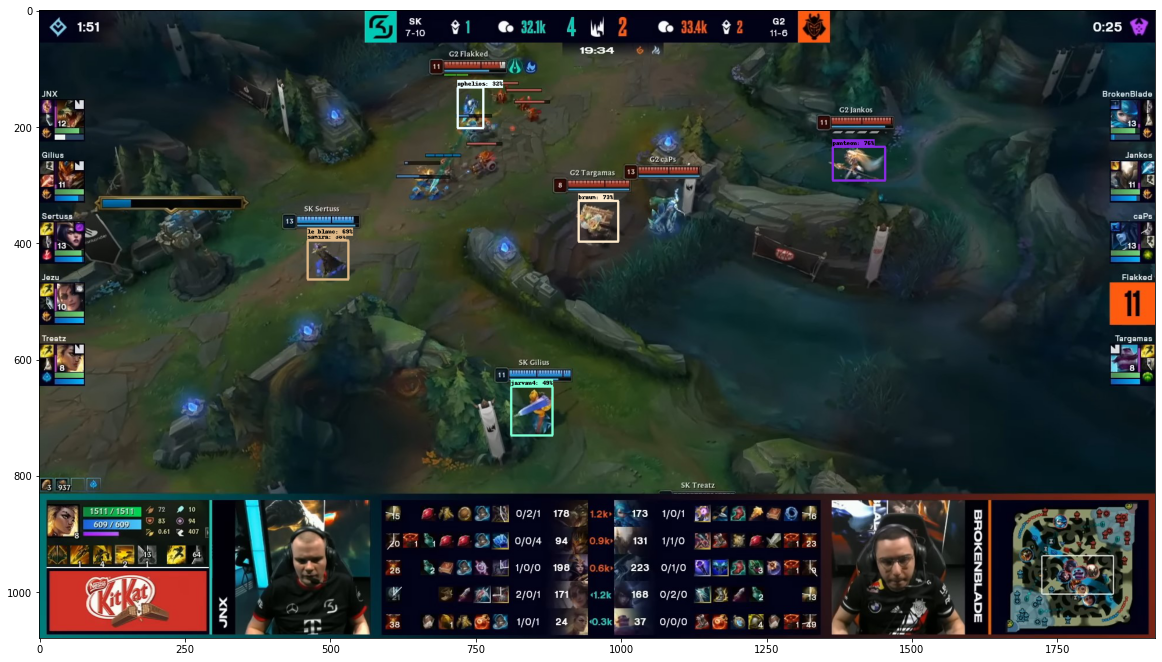

In [52]:
detections = detect_fn(img_arr)
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=10,
            min_score_thresh=.3,
            agnostic_mode=False)

plt.figure(figsize=(20, 20))
plt.imshow(image_np_with_detections)
plt.show()

Модель довольно хорошо и с большой уверенностью(в сравнении с тем, что было до этого(где она вообще не могла ничего определить, в разрешении 720p)) определяется боксы.

А вот с классами беда, на картинке - не один класс не опознан правильно, везде ошибки. И это довольно подозрительно, т.к. задача классификации - не сложная.
Либо ошибка в создании `Example`(что врядли, т.к. по классами промах между 1м и 9м элементом, например) либо я хз.

Наслоение bounding box тоже смущает, но это решаемая проблема.

## Код сохранения модели

In [ ]:
FREEZE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'exporter_main_v2.py ')

In [ ]:
command = "python {} --input_type=image_tensor --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(FREEZE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['EXPORT_PATH'])

In [ ]:
print(command)

python /content/models/research/object_detection/exporter_main_v2.py  --input_type=image_tensor --pipeline_config_path=/content/workspace/models/my_lol_hd_efficient_det/pipeline.config --trained_checkpoint_dir=/content/workspace/models/my_lol_hd_efficient_det --output_directory=/content/workspace/models/my_lol_hd_efficient_det/export


In [ ]:
!{command}

2022-08-25 18:26:55.570737: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0825 18:26:55.580087 140287841560448 ssd_efficientnet_bifpn_feature_extractor.py:146] EfficientDet EfficientNet backbone version: efficientnet-b4
I0825 18:26:55.580275 140287841560448 ssd_efficientnet_bifpn_feature_extractor.py:147] EfficientDet BiFPN num filters: 224
I0825 18:26:55.580347 140287841560448 ssd_efficientnet_bifpn_feature_extractor.py:149] EfficientDet BiFPN num iterations: 7
I0825 18:26:55.583873 140287841560448 efficientnet_model.py:143] round_filter input=32 output=48
I0825 18:26:55.606891 140287841560448 efficientnet_model.py:143] round_filter input=32 output=48
I0825 18:26:55.607044 140287841560448 efficientnet_model.py:143] round_filter input=16 output=24
I0825 18:26:55.730365 140287841560448 efficientnet_model.py:143] round_filter input=16 output=24
I0

## Копирование моделей(папку с ними) на гуглдрайв

In [ ]:
!tar -czf models.tar.gz {paths['CHECKPOINT_PATH']}

tar: Removing leading `/' from member names


In [ ]:
!cp models.tar.gz /content/drive/MyDrive/modelsTFOD